<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import warnings
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import joblib
#warnings.filterwarnings('ignore')

In [2]:
def engineer_features(df):
    df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
    df['month'] = df['time'].dt.month

    # Extract day of the month (1-31)
    df['day'] = df['time'].dt.day


    # --- New Additions ---
    # Extract hour (0-23)
    df['hour'] = df['time'].dt.hour

    # Extract minute (0-59)
    df['minute'] = df['time'].dt.minute



    # --- End of New Additions ---

    # 3. Remove the original 'time' column
    df = df.drop(columns=['time'])
    # --- Clean up and drop NaNs (first ~200 rows) ---
    df = df.dropna().reset_index(drop=True)

    return df


In [23]:

def create_labels(df, lookback=50, lookahead=100,
                                      buy_threshold=0.1, sell_threshold=0.1,
                                      adaptive_threshold=True):
    """
    Create buy/sell labels based on forward price movement.
    Simple and profitable approach: if price goes up → Buy, if price goes down → Sell

    Label 0: Hold/No action
    Label 1: Buy signal (price will go up)
    Label 2: Sell signal (price will go down)

    Parameters:
    -----------
    df : DataFrame with OHLC data
    lookback : Periods to look back for context (optional, for filtering)
    lookahead : Periods to look ahead to measure future price movement
    buy_threshold : Minimum % gain to label as Buy (e.g., 0.01 = 1%)
    sell_threshold : Minimum % loss to label as Sell (e.g., 0.01 = 1%)
    adaptive_threshold : Automatically adjust thresholds for better label distribution
    """

    labels = np.zeros(len(df))

    # First pass: Calculate potential gains/losses
    potential_gains = []
    potential_losses = []

    for i in range(len(df) - lookahead):
        current_price = df.iloc[i]['close']

        # Look ahead window
        future_window = df.iloc[i+1:i+lookahead+1]

        # Find maximum gain and maximum loss in lookahead period
        future_high = future_window['high'].max()
        future_low = future_window['low'].min()

        max_gain = (future_high - current_price) / current_price
        max_loss = (current_price - future_low) / current_price

        potential_gains.append(max_gain)
        potential_losses.append(max_loss)

    # Adaptive threshold adjustment
    if adaptive_threshold:
        # Set thresholds at percentiles to ensure good label distribution
        buy_threshold = np.percentile(potential_gains, 60)  # Top 40% of gains
        sell_threshold = np.percentile(potential_losses, 60)  # Top 40% of losses

        print(f"Adaptive thresholds:")
        print(f"  Buy threshold: {buy_threshold*100:.2f}%")
        print(f"  Sell threshold: {sell_threshold*100:.2f}%")

    # Second pass: Create labels
    for i in range(len(df) - lookahead):
        current_price = df.iloc[i]['close']

        # Look ahead window
        future_window = df.iloc[i+1:i+lookahead+1]

        # Calculate maximum gain and loss
        future_high = future_window['high'].max()
        future_low = future_window['low'].min()

        max_gain = (future_high - current_price) / current_price
        max_loss = (current_price - future_low) / current_price

        # Decision logic: Prioritize the larger movement
        if max_gain >= buy_threshold and max_loss >= sell_threshold:
            # Both directions have potential - choose the stronger one
            if max_gain > max_loss:
                labels[i] = 1  # Buy
            else:
                labels[i] = 2  # Sell
        elif max_gain >= buy_threshold:
            labels[i] = 1  # Buy
        elif max_loss >= sell_threshold:
            labels[i] = 2  # Sell
        else:
            labels[i] = 0  # Hold

    df['label'] = labels.astype(int)

    # Print label distribution
    unique, counts = np.unique(labels, return_counts=True)
    label_dist = dict(zip(unique, counts))
    total = len(labels)

    print(f"\nLabel Distribution:")
    print(f"  Hold (0): {label_dist.get(0, 0):5d} ({label_dist.get(0, 0)/total*100:.1f}%)")
    print(f"  Buy (1):  {label_dist.get(1, 0):5d} ({label_dist.get(1, 0)/total*100:.1f}%)")
    print(f"  Sell (2): {label_dist.get(2, 0):5d} ({label_dist.get(2, 0)/total*100:.1f}%)")

    return df


def create_labels_with_holding_period(df, lookback=10, lookahead=20,
                                       profit_target=0.015, stop_loss=0.01,
                                       min_hold_periods=5):
    """
    Advanced version: Create labels based on achieving profit targets or stop losses
    within the lookahead period, with minimum holding period requirement.

    This simulates actual trading: Buy if profit target can be reached,
    Sell if we'd hit stop loss or price drops.
    """

    labels = np.zeros(len(df))

    for i in range(len(df) - lookahead):
        current_price = df.iloc[i]['close']
        future_window = df.iloc[i+1:i+lookahead+1]

        # Track if we hit profit target or stop loss
        buy_signal = False
        sell_signal = False

        # Simulate holding and see if we hit targets
        for j in range(len(future_window)):
            future_high = future_window.iloc[j]['high']
            future_low = future_window.iloc[j]['low']

            # Check if we'd hit profit target (for buy)
            if (future_high - current_price) / current_price >= profit_target:
                if j >= min_hold_periods:  # Minimum holding period
                    buy_signal = True
                    break

            # Check if we'd hit stop loss (for sell)
            if (current_price - future_low) / current_price >= stop_loss:
                if j >= min_hold_periods:
                    sell_signal = True
                    break

        # If neither target hit, check end-of-period price
        if not buy_signal and not sell_signal:
            final_price = future_window.iloc[-1]['close']
            price_change = (final_price - current_price) / current_price

            if price_change >= profit_target:
                buy_signal = True
            elif price_change <= -stop_loss:
                sell_signal = True

        # Assign labels
        if buy_signal and not sell_signal:
            labels[i] = 1
        elif sell_signal and not buy_signal:
            labels[i] = 2
        elif buy_signal and sell_signal:
            # Both hit - choose based on which came first (already handled above)
            pass
        # else: Hold (0)

    df['label'] = labels.astype(int)

    # Print statistics
    unique, counts = np.unique(labels, return_counts=True)
    label_dist = dict(zip(unique, counts))
    total = len(labels)

    print(f"\nLabel Distribution (Profit Target: {profit_target*100:.1f}%, Stop Loss: {stop_loss*100:.1f}%):")
    print(f"  Hold (0): {label_dist.get(0, 0):5d} ({label_dist.get(0, 0)/total*100:.1f}%)")
    print(f"  Buy (1):  {label_dist.get(1, 0):5d} ({label_dist.get(1, 0)/total*100:.1f}%)")
    print(f"  Sell (2): {label_dist.get(2, 0):5d} ({label_dist.get(2, 0)/total*100:.1f}%)")

    return df


def create_labels_balanced(df, lookahead=20, target_buy_ratio=0.3, target_sell_ratio=0.3):
    """
    Create balanced labels by selecting top opportunities for buy and sell.
    Ensures you have meaningful buy/sell signals, not too many holds.

    Parameters:
    -----------
    target_buy_ratio : Target percentage of Buy labels (e.g., 0.3 = 30%)
    target_sell_ratio : Target percentage of Sell labels (e.g., 0.3 = 30%)
    """

    labels = np.zeros(len(df))
    gains = np.zeros(len(df))
    losses = np.zeros(len(df))

    # Calculate all gains and losses
    for i in range(len(df) - lookahead):
        current_price = df.iloc[i]['close']
        future_window = df.iloc[i+1:i+lookahead+1]

        future_high = future_window['high'].max()
        future_low = future_window['low'].min()

        gains[i] = (future_high - current_price) / current_price
        losses[i] = (current_price - future_low) / current_price

    # Find top buy opportunities
    valid_indices = range(len(df) - lookahead)
    n_buy = int(len(valid_indices) * target_buy_ratio)
    n_sell = int(len(valid_indices) * target_sell_ratio)

    # Get top buy signals (highest gains)
    top_buy_indices = np.argsort(gains)[-n_buy:]
    labels[top_buy_indices] = 1

    # Get top sell signals (highest losses)
    top_sell_indices = np.argsort(losses)[-n_sell:]

    # Avoid conflicts: if an index is already labeled as buy, don't relabel as sell
    for idx in top_sell_indices:
        if labels[idx] == 0:  # Only label if not already a buy signal
            labels[idx] = 2

    df['label'] = labels.astype(int)

    # Print statistics
    unique, counts = np.unique(labels, return_counts=True)
    label_dist = dict(zip(unique, counts))
    total = len(labels)

    print(f"\nBalanced Label Distribution:")
    print(f"  Hold (0): {label_dist.get(0, 0):5d} ({label_dist.get(0, 0)/total*100:.1f}%)")
    print(f"  Buy (1):  {label_dist.get(1, 0):5d} ({label_dist.get(1, 0)/total*100:.1f}%)")
    print(f"  Sell (2): {label_dist.get(2, 0):5d} ({label_dist.get(2, 0)/total*100:.1f}%)")

    avg_buy_gain = gains[top_buy_indices].mean()
    avg_sell_loss = losses[labels == 2].mean()
    print(f"\nAverage potential:")
    print(f"  Buy signals: {avg_buy_gain*100:.2f}% gain")
    print(f"  Sell signals: {avg_sell_loss*100:.2f}% loss avoided")

    return df


In [4]:
def add_technical_indicators(df):
    """Add RSI, MACD, and other technical indicators"""

    # RSI (Relative Strength Index)
    def calculate_rsi(data, period=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['rsi'] = calculate_rsi(df['close'])

    # MACD (Moving Average Convergence Divergence)
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # Moving Averages
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()

    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)

    # ATR (Average True Range)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['atr'] = true_range.rolling(14).mean()

    # Momentum
    df['momentum'] = df['close'] - df['close'].shift(4)

    # Volume indicators
    df['volume_sma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma']

    # Price rate of change
    df['roc'] = ((df['close'] - df['close'].shift(10)) / df['close'].shift(10)) * 100

    # Drop rows with NaN values
    df = df.dropna()

    return df

In [11]:
def plot_signals(df):
    """Plot price chart with buy/sell signals"""
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot close price
    ax.plot(df.index, df['close'], label='Close Price', color='blue', alpha=0.6)



    # Plot buy signals
    buy_signals = df[df['label'] == 1]
    ax.scatter(buy_signals.index, buy_signals['close'],
               color='green', marker='^', s=100, label='Buy Signal', zorder=5)

    # Plot sell signals
    sell_signals = df[df['label'] == 2]
    ax.scatter(sell_signals.index, sell_signals['close'],
               color='red', marker='v', s=100, label='Sell Signal', zorder=5)

    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Trading Signals: Buy and Sell Points')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('trading_signals.png', dpi=300)
    plt.show()

    print(f"\nSignal Distribution:")
    print(f"Hold/No Action (0): {len(df[df['label'] == 0])}")
    print(f"Buy Signals (1): {len(df[df['label'] == 1])}")
    print(f"Sell Signals (2): {len(df[df['label'] == 2])}")

In [9]:


print("="*70)
print("TRADING SIGNAL CLASSIFICATION SYSTEM")
print("="*70)

# Step 1: Load data from Excel
print("\nStep 1: Loading data from Excel file...")
t_symbol = ["BTCUSD"]
n = 0
m_label = "Generated"+t_symbol[n]






TRADING SIGNAL CLASSIFICATION SYSTEM

Step 1: Loading data from Excel file...


In [ ]:

df = pd.read_csv(m_label+ " dbot.csv")
df = engineer_features(df)

In [7]:
df

,open,high,low,close,volume,spread,month,day,hour,minute
0,13.69,13.78,13.40,13.61,69,0,7,21,10,0
1,13.61,13.81,13.45,13.70,64,0,7,22,10,0
2,13.70,13.76,13.51,13.68,49,0,7,23,10,0
3,13.68,14.10,13.60,13.98,71,0,7,24,10,0
4,13.98,14.72,13.76,14.05,186,0,7,25,10,0
...,...,...,...,...,...,...,...,...,...,...
728568,93008.50,93009.38,92861.00,92943.50,805,2522,12,3,13,40
728569,92941.00,93086.00,92941.00,93016.00,723,2522,12,3,13,45
728570,93015.00,93069.93,92978.44,92999.00,858,2522,12,3,13,50
728571,93000.00,93058.00,92985.00,93038.00,562,2520,12,3,13,55


In [25]:
# Step 3: Create labels
print("\nStep 3: Creating buy/sell labels...")
df = create_labels_balanced(df)



Step 3: Creating buy/sell labels...

Balanced Label Distribution:
  Hold (0): 344204 (47.2%)
  Buy (1):  218565 (30.0%)
  Sell (2): 165804 (22.8%)

Average potential:
  Buy signals: 1.67% gain
  Sell signals: 1.55% loss avoided



Step 5: Visualizing trading signals...


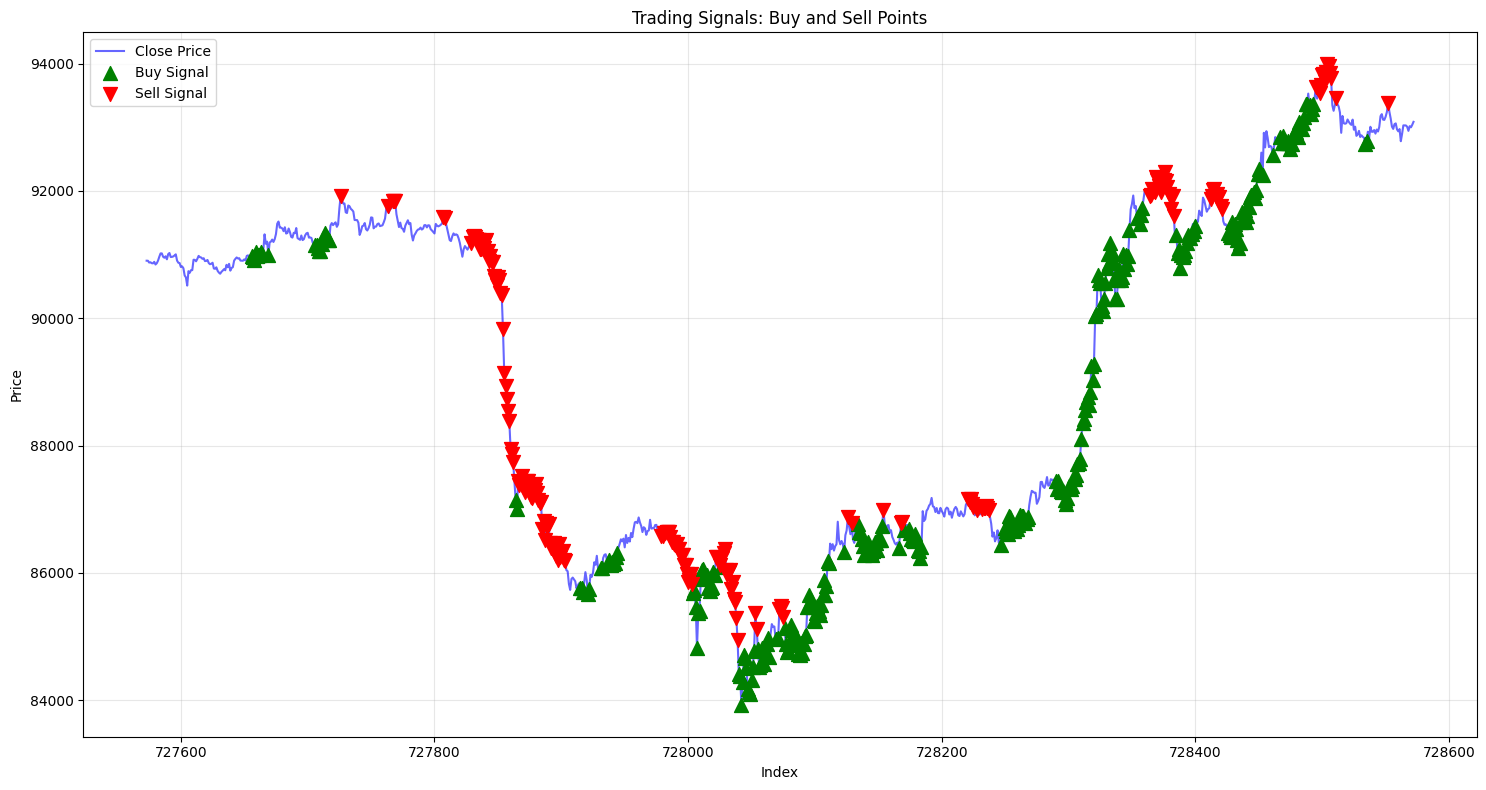


Signal Distribution:
Hold/No Action (0): 506
Buy Signals (1): 306
Sell Signals (2): 188


In [26]:

# Step 5: Visualize signals
print("\nStep 5: Visualizing trading signals...")
plot_signals(df[-1000:])



In [27]:
# Step 4: Add technical indicators
print("\nStep 4: Adding technical indicators...")
df = add_technical_indicators(df)
print(f"Final dataset shape: {df.shape}")


Step 4: Adding technical indicators...
Final dataset shape: (728514, 26)


In [29]:

joblib.dump(df, 'df.joblib')

['df.joblib']

In [2]:
df = joblib.load('df.joblib')

In [3]:
print(f"Data loaded: {len(df)} rows")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Data loaded: 728514 rows
Memory usage: 138.95 MB


In [4]:
df

,open,high,low,close,volume,spread,month,day,hour,minute,...,sma_50,ema_12,bb_middle,bb_upper,bb_lower,atr,momentum,volume_sma,volume_ratio,roc
49,5.03,5.49,4.63,4.77,147,0,9,10,10,0,...,10.2458,7.114446,8.4160,12.040086,4.791914,0.910714,-2.09,138.45,1.061755,-45.733788
50,4.77,7.40,4.60,5.86,452,0,9,11,10,0,...,10.0908,6.921454,8.1435,11.669621,4.617379,1.040000,-1.33,159.70,2.830307,-28.536585
51,5.86,6.58,5.41,6.08,213,0,9,12,10,0,...,9.9384,6.792000,7.9025,11.291565,4.513435,1.050000,-0.45,162.45,1.311173,-25.943971
52,6.08,6.09,5.70,5.80,51,0,9,13,10,0,...,9.7808,6.639385,7.6455,10.838601,4.452399,1.033571,0.77,160.25,0.318253,-31.603774
53,5.80,5.85,5.32,5.62,89,0,9,14,10,0,...,9.6136,6.482556,7.3840,10.318251,4.449749,1.039286,0.85,162.60,0.547355,-31.295844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728568,93008.50,93009.38,92861.00,92943.50,805,2522,12,3,13,40,...,92998.6384,92992.919147,93048.3000,93320.990956,92775.609044,162.823571,-86.00,1061.25,0.758539,-0.125725
728569,92941.00,93086.00,92941.00,93016.00,723,2522,12,3,13,45,...,92997.7084,92996.470047,93043.3250,93314.480087,92772.169913,157.323571,-12.50,1023.10,0.706676,0.053783
728570,93015.00,93069.93,92978.44,92999.00,858,2522,12,3,13,50,...,92995.2484,92996.859271,93035.0500,93300.679718,92769.420282,153.314286,-29.50,994.45,0.862788,0.067789
728571,93000.00,93058.00,92985.00,93038.00,562,2520,12,3,13,55,...,92994.3084,93003.188614,93025.0000,93272.747324,92777.252676,147.207143,30.00,951.70,0.590522,0.071527


In [5]:
# Prepare features and labels
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'spread',
                'hour', 'minute', 'day', 'month',
                'rsi', 'macd', 'macd_signal', 'macd_hist',
                'sma_20', 'sma_50', 'ema_12',
                'bb_upper', 'bb_middle', 'bb_lower', 'atr',
                'momentum', 'volume_ratio', 'roc']

X = df[feature_cols].values
y = df['label'].values

X_real = X[-1000:]
y_real = y[-1000:]

X = X[:-1000]
y = y[:-1000]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_real_scaled = scaler.transform(X_real)

In [6]:

joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [ ]:

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=1),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'SVC': SVC(kernel='rbf', random_state=42, verbose=1),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=1)
}

results = {}

print("\n" + "="*70)
print("TRAINING CLASSIFICATION MODELS")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    joblib.dump(model, m_label + name + '.joblib')
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png', dpi=300)
    plt.show()


TRAINING CLASSIFICATION MODELS

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min


In [ ]:
"""Train a deep neural network for classification"""

print("\n" + "="*70)
print("TRAINING DEEP NEURAL NETWORK")
print("="*70)

# Convert labels to categorical
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)
y_live_cat = keras.utils.to_categorical(y_real,num_classes)
# Build model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()



In [ ]:
es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
# Train
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=[es, rlr, mc ],
)



In [ ]:

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('dnn_training_history.png', dpi=300)
plt.show()



In [ ]:

model = load_model(m_label + 'lstm_best.keras')
# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\n\nDeep Neural Network Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Deep Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_DNN.png', dpi=300)
plt.show()

In [ ]:

# Summary
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

for name, result in results.items():
    print(f"{name}: {result['accuracy']:.4f}")
print(f"Deep Neural Network: {accuracy:.4f}")

print("\nAll models trained successfully!")
print("Confusion matrices and plots saved to current directory.")